# Scan parameters: Are there binding rates that can produce an adaptable circuit?

Circuits that can readjust back to their steady state following a signal input.

In [1]:

from bioreaction.simulation.med_sim import get_int_med_model, basic_de, MedSimParams, MedSimInternalState
from bioreaction.model.data_tools import construct_model_fromnames
from bioreaction.simulation.basic_sim import basic_de_sim, convert_model, BasicSimParams, BasicSimState
from bioreaction.model.data_containers import Impulse
import bioreaction
from tqdm import tqdm
import diffrax as dfx
import jax
import pandas as pd
import jax.random as jr
import jax.numpy as jnp
import numpy as np
from copy import deepcopy
from functools import partial
import os
import sys

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-paper')
# plt.style.use('seaborn-v0_8')

# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.8"
os.environ["TF_CPP_MIN_LOG_LOVEL"] = "0"
jax.config.update('jax_platform_name', 'cpu')


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


from src.utils.results.analytics.timeseries import generate_analytics, get_precision, get_sensitivity, get_step_response_times
from src.utils.results.analytics.naming import get_true_names_analytics, get_true_interaction_cols
from src.utils.modelling.deterministic import bioreaction_sim_dfx_expanded
from src.utils.misc.units import per_mol_to_per_molecule
from src.utils.misc.type_handling import flatten_listlike
from src.utils.misc.numerical import make_symmetrical_matrix_from_sequence, triangular_sequence
from src.srv.sequence_exploration.sequence_analysis import b_tabulate_mutation_info
import src
from tests.shared import five_circuits, CONFIG


config = deepcopy(CONFIG)


In [2]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [3]:
jax.devices()

xla_bridge.py:backends():355: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker:  INFO
xla_bridge.py:backends():355: Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter CUDA Host INFO
xla_bridge.py:backends():355: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client' INFO
xla_bridge.py:backends():355: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this. INFO


[CpuDevice(id=0)]

In [4]:
# size = 3000
# key = jr.PRNGKey(0)
# x = jr.normal(key, (size, size), dtype=jnp.float32)
# %timeit jax.jit(jnp.dot, backend='cpu')(x, x.T) #.block_until_ready()  # runs on the GPU

In [5]:
# %timeit jax.jit(jnp.dot, backend='gpu')(x, x.T) #.block_until_ready()  # runs on the GPU


A single model:

In [28]:
num_species = 3
input_species_idx = 0
output_species_idx = 1

Keq = np.array(
    [[1, 2, 1],
     [2, 1, 0.5],
     [1, 0.5, 2]]
)
# From src/utils/common/configs/RNA_circuit/molecular_params.json
a=np.ones(3) * 0.08333
d=np.ones(3) * 0.0008333
ka=np.ones_like(Keq) * per_mol_to_per_molecule(1000000)
kd=ka/Keq

med_model = bioreaction.templates.generate_rnabinding_medsim(
    num_species=num_species,
    a=a, d=d, ka=ka,
    kd=ka/Keq,
    impulse_idx=0
)

s0 = np.concatenate([np.array([1.0, 1.0, 1.0]), np.zeros(len(med_model.species[num_species:]))])

# impulse = Impulse(target=med_model.species[:num_species][input_species_idx], delta_target=20, time=100.0, impulse_width=0.0)
med_model.impulses = []
poiss_simmed = jnp.zeros(len(med_model.reactions))
brown_simmed = jnp.zeros(len(med_model.reactions))

# Making the params for the simulation, how things are simutated and for how long.
int_med_params = MedSimParams(delta_t= 0.01, t_start=0.0, t_end = 1000.0, poisson_sim_reactions=poiss_simmed, brownian_sim_reaction=brown_simmed)
int_med_model = get_int_med_model(med_model)
int_med_state = MedSimInternalState(concentrations=s0, other_factors=jnp.zeros(len(med_model.other_factors)))
med_model.species



[Species: RNA 0,
 Species: RNA 1,
 Species: RNA 2,
 Species: RNA 0-0,
 Species: RNA 0-1,
 Species: RNA 0-2,
 Species: RNA 1-1,
 Species: RNA 1-2,
 Species: RNA 2-2]

In [29]:

def update_model_rates(model, a=None, d=None, ka=None, kd=None):
    for i, r in enumerate(model.reactions):
        if not r.input:  # 0 -> RNA
            if a is not None:
                model.reactions[i].forward_rate = a[model.species.index(
                    r.output[0])]
                model.reactions[i].reverse_rate = 0
        elif not r.output:  # RNA -> 0
            if d is not None:
                model.reactions[i].forward_rate = d[model.species.index(
                    r.input[0])]
                model.reactions[i].reverse_rate = 0
        else:
            if ka is not None:
                model.reactions[i].forward_rate = ka[model.species.index(r.input[0]),
                                                    model.species.index(r.input[1])]
            if kd is not None:
                model.reactions[i].reverse_rate = kd[model.species.index(r.input[0]),
                                                    model.species.index(r.input[1])]
    return model


In [30]:
med_model = update_model_rates(med_model, a, d, ka, kd)

In [10]:
result_1 = jax.jit(basic_de, backend='cpu')(int_med_state, int_med_model, int_med_params)
# result_1 = basic_de(int_med_state, int_med_model, int_med_params)

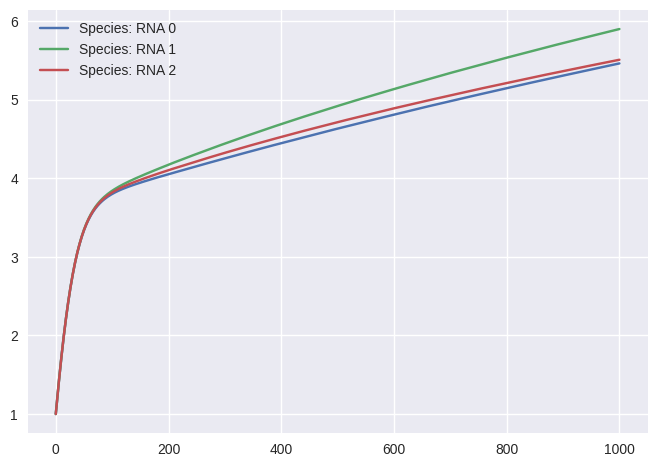

In [11]:

plt.plot(result_1.ts, np.array(result_1.ys.concentrations)[:, :num_species], label=[str(s) for s in med_model.species[:num_species]])
plt.legend()

### Checking that new basic de sim is the same as bioreactions sim

Also checking times to simulate for non-vmapped case.

In [9]:
model = construct_model_fromnames([str(i) for i in range(num_species)])
model.species = model.species[-num_species:] + model.species[:-num_species]
model = update_model_rates(model, a, d, ka, kd)
sim_model = convert_model(model)
starting_state = BasicSimState(concentrations=s0)
params = BasicSimParams(delta_t=0.01, total_time=1000.0)

state = basic_de_sim(starting_state=starting_state, model=sim_model, params=params)
results_species = np.concatenate([np.expand_dims(starting_state.concentrations, axis=0), state[1]])
t = np.arange(params.total_time / params.delta_t) * params.delta_t


In [13]:
result_dfx = jax.jit(
    partial(bioreaction_sim_dfx_expanded, signal=lambda x: x),
    backend='cpu')(y0=s0, t0=0.0, t1=params.total_time, dt0=params.delta_t,
                   inputs=sim_model.inputs, outputs=sim_model.outputs,
                   forward_rates=sim_model.forward_rates, reverse_rates=sim_model.reverse_rates,
                   signal_onehot=jnp.zeros(len(model.species)))
result_dfx_y = result_dfx.ys[result_dfx.ts < np.inf]
result_dfx_t = result_dfx.ts[result_dfx.ts < np.inf]


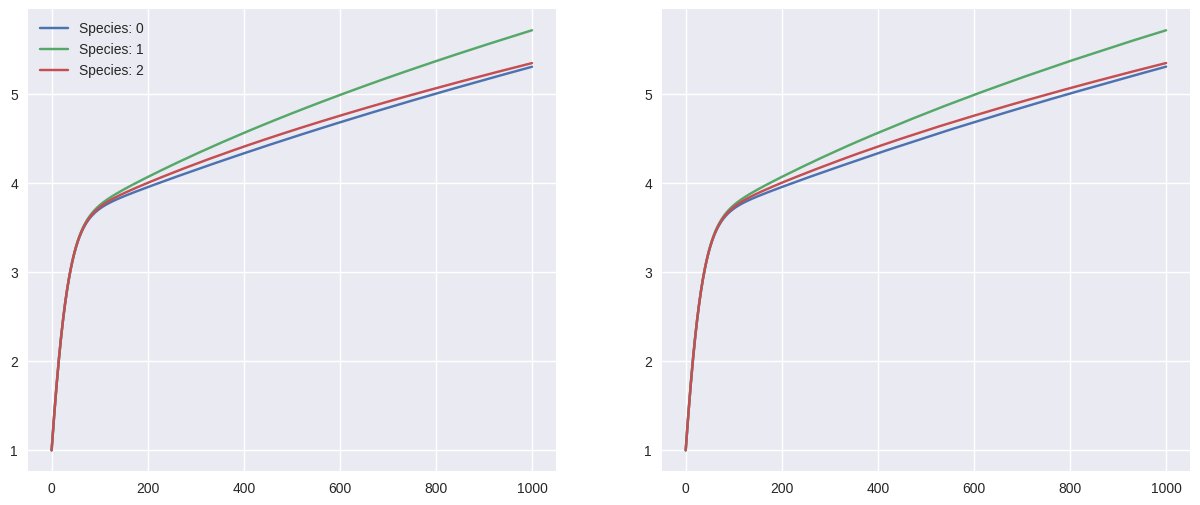

In [14]:
plt.figure(figsize=(15, 6))
ax = plt.subplot(1,2,1)
plt.plot(t, results_species[:, :num_species])
plt.legend(model.species[:num_species])

ax = plt.subplot(1,2,2)
# till = int(5 / params.delta_t)
plt.plot(result_dfx_t, result_dfx_y[:, :num_species])


### Simulation comparison

So far, we have 
- `basic_de_sim`: a very basic for loop simulator 
- `bioreaction_sim_dfx_expanded`: uses essentially the same same core function as the loop, but with a better numerical solver
- `basic_de`: same as bioreaction_sim_dfx_expanded, except the Med Sim model includes noise terms for some of the processes.

The for loop is the fastest since it uses the fewest steps. Used dt=0.01 for both runs. For t_end = 1000, `vmap1` and `vmap3` took ca. 2 mins, while `vmap2` took ca. 2s. For t_end=10000, `vmap1` and `vmap3` took ca. 10 mins, while `vmap2` took ca. 15s.

Even for long time steps, the loop is very similar to the Tsit5 solver. 

In [15]:
params.total_time = 100.0
params.delta_t = 0.01
int_med_params.t_end = 100.0
int_med_params.delta_t = 0.01

def to_vmap_dfx(reverse_rates):
    return bioreaction_sim_dfx_expanded(y0=s0, t0=0, t1=params.total_time, dt0=params.delta_t,
                                        inputs=sim_model.inputs, outputs=sim_model.outputs,
                                        forward_rates=sim_model.forward_rates, reverse_rates=reverse_rates,
                                        signal=lambda x: x, signal_onehot=np.zeros(len(model.species)),
                                        saveat=dfx.SaveAt(ts=jnp.linspace(0, params.total_time, 100)),
                                        max_steps=int(params.total_time * 1.5 / params.delta_t))


def to_vmap_basic(reverse_rates):
    sim_model.reverse_rates = reverse_rates
    return basic_de_sim(starting_state=starting_state, model=sim_model, params=params)


def to_vmap_basic_med(reverse_rates):
    int_med_model.reactions.reverse_rates = reverse_rates
    return basic_de(int_med_state, int_med_model, int_med_params)


vmap1 = jax.jit(jax.vmap(to_vmap_dfx))
vmap2 = jax.jit(jax.vmap(to_vmap_basic))
vmap3 = jax.jit(jax.vmap(to_vmap_basic_med))


In [16]:

test_amount = 20
revs = np.array([sim_model.reverse_rates + i for i in range(test_amount)])

In [17]:
res1 = vmap1(revs)
tf = np.argmax(res1.ts >= np.inf)
tf = res1.ts.shape[1] if tf == 0 else tf

In [18]:
res2 = vmap2(revs)
res2_ = np.concatenate([np.repeat(np.expand_dims(np.expand_dims(starting_state.concentrations, axis=0), axis=0), repeats=test_amount, axis=0), res2[1]], axis=1)

In [19]:
res3 = vmap3(revs)

Compare the simulation methods. They should be roughly similar looking.

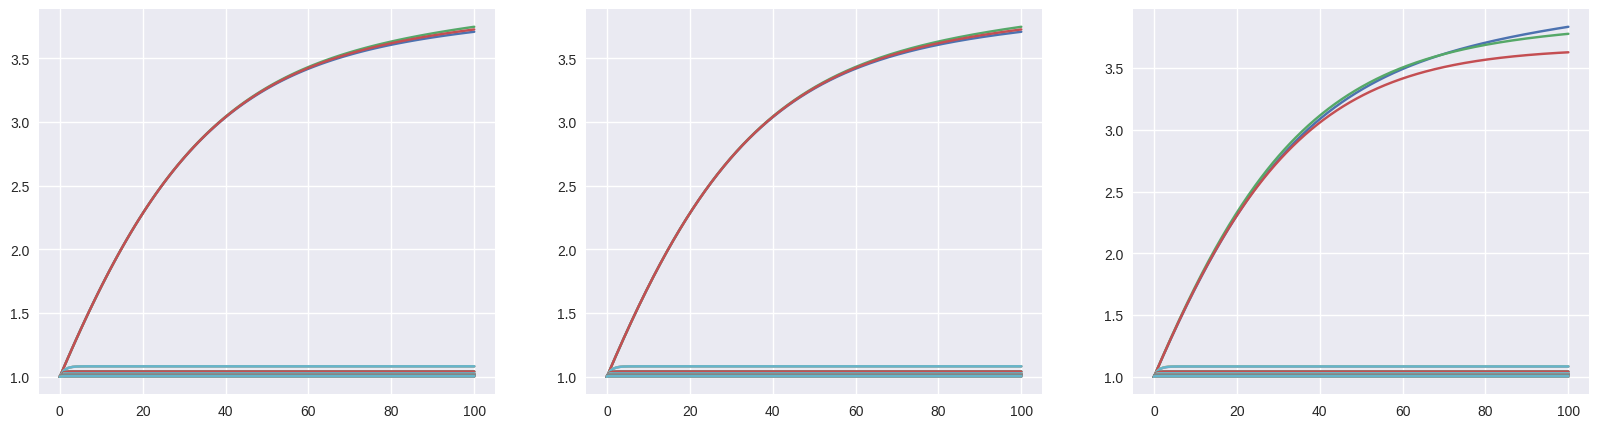

In [20]:
res1.ys[res1.ts < np.inf]
res1.ts[res1.ts < np.inf]
plt.figure(figsize=(20, 5))
for p in range(test_amount):
    ax = plt.subplot(1,3,1)
    plt.plot(res1.ts[p, :tf], res1.ys[p, :tf, :num_species])
    ax = plt.subplot(1,3,2)
    plt.plot(np.arange(res2_.shape[1]) * params.delta_t, res2_[p, :, :num_species])
    ax = plt.subplot(1,3,3)
    plt.plot(res3.ts[p], res3.ys.concentrations[p, :, :num_species])

# plt.legend(model.species[:num_species])

## Can we scale the gene circuit parameters to make the simulation faster?

The answer is it scales with dt and concentration, so can make your sim unstable for the same number of time steps. Multiplying the rates by 10 is like multiplying the dt by 10, except the dt stays the same per time step so we have to divide the total time by 10 too to get the actual time simulated. Instability may still result from this.

The graph for 1000 time steps with dt 0.01 but rate scaling of 100 approximately looks the same as the graph for simulating for 100000 time steps.

In [21]:
sim_model = convert_model(model)
scale_factor = 100
params = BasicSimParams(delta_t=1, total_time=100000.0)

sim_result = basic_de_sim(starting_state=starting_state, model=sim_model, params=params)
sim_result_ = np.concatenate([np.expand_dims(starting_state.concentrations, axis=0), sim_result[1]])
t_sim = np.arange(params.total_time / params.delta_t) * params.delta_t

In [22]:
sim_model.reverse_rates = sim_model.reverse_rates * scale_factor
sim_model.forward_rates = sim_model.forward_rates * scale_factor
# sim_model.reverse_rates = sim_model.reverse_rates / sim_model.forward_rates.min()
# sim_model.forward_rates = sim_model.forward_rates / sim_model.forward_rates.min()


In [23]:
params = BasicSimParams(delta_t=0.01, total_time=1000.0)
starting_state

norm_sim_result = basic_de_sim(starting_state=starting_state, model=sim_model, params=params)
norm_sim_result_ = np.concatenate([np.expand_dims(starting_state.concentrations, axis=0), norm_sim_result[1]])
t = np.arange(params.total_time / params.delta_t) * params.delta_t * scale_factor

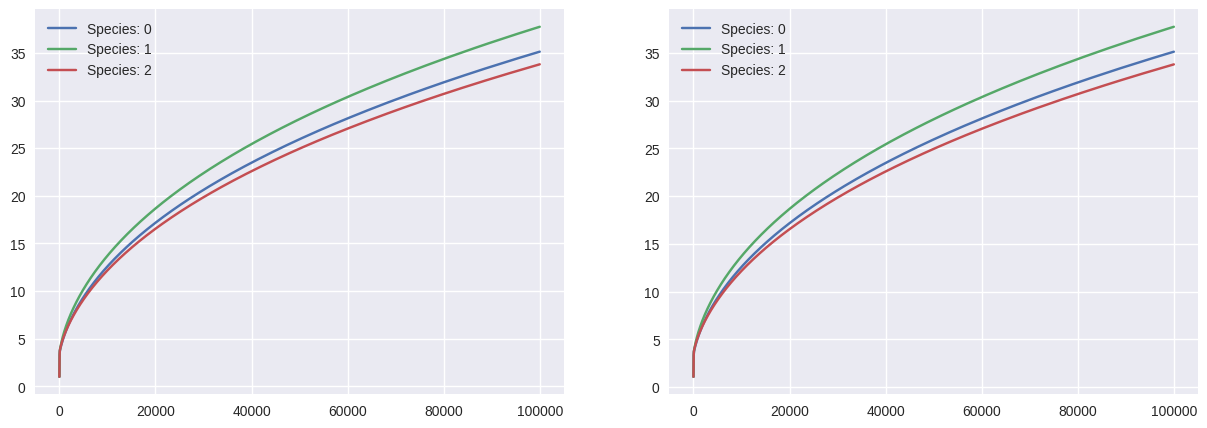

In [24]:


plt.figure(figsize=(15,5))
ax = plt.subplot(1,2,1)
plt.plot(t, norm_sim_result_[:, :num_species])
plt.legend(model.species[:num_species])
ax = plt.subplot(1,2,2)
plt.plot(t_sim, sim_result_[1:, :num_species])
plt.legend(model.species[:num_species])



## Scan: develop methods

Scan a bunch of dissociation rates to find adaptive behaviors. First we have to make functions to accomplish that and make it all fit in GPU memory

Make matrices for different dissociation rates. Using equilibrium constants from 0.01 to 5.

In [36]:


K_eqs_range = np.array([0.1, 0.5, 1.0, 1.5, 9])
num_Keqs = np.size(K_eqs_range)
num_unique_interactions = np.math.factorial(num_species)

# Create matrices
def define_matrices(num_species, size_interaction_array, num_unique_interactions, num_analytic_types):
    matrix_dimensions = tuple(
        [num_species] + [size_interaction_array]*num_unique_interactions)
    matrix_size = num_species * \
        np.power(size_interaction_array, num_unique_interactions)
    assert matrix_size == np.prod(list(
        matrix_dimensions)), 'Something is off about the intended size of the matrix'

    all_analytic_matrices = []
    for _analytic in range(num_analytic_types):
        all_analytic_matrices.append(np.zeros(
            matrix_dimensions, dtype=np.float32))
    return all_analytic_matrices


# Set loop vars
analytic_types = ['precision']
all_analytic_matrices = define_matrices(
    num_species, num_Keqs, num_unique_interactions, len(analytic_types))

# total_iterations = np.power(
#     size_interaction_array, num_unique_interactions)
total_iterations = np.power(num_Keqs, num_unique_interactions)
total_processes = 1
sub_process = 0
num_iterations = int(total_iterations / total_processes)
starting_iteration = int(num_iterations * sub_process)
end_iteration = int(num_iterations * (sub_process + 1))

print('Making ', num_iterations, ' parameter combinations for equilibrium constants range: ', K_eqs_range)


Making  15625  parameter combinations for equilibrium constants range:  [0.1 0.5 1.  1.5 9. ]


In [37]:
pows = np.power(num_Keqs, np.arange(num_unique_interactions))
num_to_skip = sum([sum(pows[i:]) for i in range(1, len(pows[:]))])  # It's actually 2599051 for 13 K_eq combos
num_to_skip

18555

In [38]:
def make_keqs():
    K_eqs = np.zeros((num_iterations, num_species, num_species))
    pows = np.power(num_Keqs, np.arange(num_unique_interactions))
    for i in range(num_iterations):
        interaction_strength_choices = np.floor(
            np.mod(i / pows, num_Keqs)).astype(int)
        if interaction_strength_choices[1] < interaction_strength_choices[3]:
            continue
        flat_triangle = K_eqs_range[list(
            interaction_strength_choices)]
        K_eqs[i] = make_symmetrical_matrix_from_sequence(
            flat_triangle, num_species)
    return K_eqs

K_eqs = jax.jit(make_keqs, backend='cpu')()
didx = np.flatnonzero((K_eqs == 0).all((1,2)))
K_eqs = np.delete(K_eqs, didx, axis=0)

Propagate equilibrium constants into rates of dissociation, ie rates of reverse interactions.

In [41]:
def make_reverse_rates(med_model, reverse_rates, interaction_matrices):
    index_translation = []
    for i, r in enumerate(med_model.reactions):
        if r.output and r.input:
            index_translation.append([i, med_model.species.index(r.input[0]),
                                      med_model.species.index(r.input[1])])
    reverse_rates = np.repeat(
        np.expand_dims(reverse_rates, axis=0),
        interaction_matrices.shape[0], axis=0
    )
    for i, k, j in index_translation:
        reverse_rates[:, i] = interaction_matrices[:, k, j]
    return reverse_rates

kds = ka / K_eqs
sim_model = convert_model(model)
b_reverse_rates = make_reverse_rates(med_model, sim_model.reverse_rates, kds)


In [29]:
print('Number of runs: ', kds.shape[0])

Number of runs:  9375


In [30]:
dt_base = 0.1
b_reverse_rates[0].max() / kds.min()

89.9999986561085

In [31]:
kds.min()

0.00016773121888888888

In [32]:
np.round(np.unique(kds) / kds.max(), 1)

array([0. , 0.1, 0.1, 0.2, 1. ])

In [33]:
np.unique(kds)
np.argmax(np.unique(kds) == np.unique(kds)[1])

1

Simulate all the interactions. First find the steady states (takes quite a lot of time steps).

In [34]:
def clear_gpu():
    backend = jax.lib.xla_bridge.get_backend()
    for buf in backend.live_buffers(): buf.delete()

clear_gpu()

In [35]:

# int_med_params = MedSimParams(delta_t= 0.1, t_start=0.0, t_end = 300000.0, poisson_sim_reactions=poiss_simmed, brownian_sim_reaction=brown_simmed)
# int_med_model = get_int_med_model(med_model)
# int_med_state = MedSimInternalState(concentrations=s0, other_factors=jnp.zeros(len(med_model.other_factors)))

# sim_dfx = partial(bioreaction_sim_dfx_expanded,
#                   y0=s0, t0=int_med_params.t_start, t1=int_med_params.t_end, dt0=int_med_params.delta_t,
#                   inputs=int_med_model.reactions.inputs, outputs=int_med_model.reactions.outputs,
#                   forward_rates=int_med_model.reactions.forward_rates,
#                   signal=lambda x: x, signal_onehot=np.zeros(len(med_model.species)),
#                   saveat=dfx.SaveAt(ts=jnp.linspace(int_med_params.t_start, int_med_params.t_end, 100)),
#                   max_steps=16**6)
# def to_vmap_dfx(reverse_rates):
#     return sim_dfx(reverse_rates=reverse_rates)

# vmap_dfx = jax.jit(jax.vmap(to_vmap_dfx))

params.total_time = 200000.0
params.delta_t = 0.1
model = update_model_rates(model, a=a)
sim_model = convert_model(model)

def to_vmap_basic(reverse_rates):
    sim_model.reverse_rates = reverse_rates
    return basic_de_sim(starting_state=starting_state, model=sim_model, params=params)

vmap_basic = jax.jit(jax.vmap(to_vmap_basic), backend='gpu')




In [36]:
batchsize = 30
def get_full_steady_states(total_time):

    def to_vmap_basic(reverse_rates):
        sim_model.reverse_rates = reverse_rates
        return basic_de_sim(starting_state=starting_state, model=sim_model, params=params)

    vmap_basic = jax.jit(jax.vmap(to_vmap_basic), backend='gpu')
    steady_state_results = vmap_basic(b_reverse_rates[-batchsize:])
    steady_states = np.array(np.concatenate([np.repeat(np.expand_dims(np.expand_dims(starting_state.concentrations, axis=0), axis=0), repeats=batchsize, axis=0), steady_state_results[1][:, ::int(params.total_time/1000), :]], axis=1))
    for ti in tqdm(range(0, total_time, int(params.total_time))):

        def to_vmap_basic(starting_state, reverse_rates):
            sim_model.reverse_rates = reverse_rates
            return basic_de_sim(starting_state=BasicSimState(concentrations=starting_state), model=sim_model, params=params)

        vmap_basic = jax.jit(jax.vmap(to_vmap_basic), backend='gpu')
        steady_state_results = vmap_basic(steady_state_results[0], b_reverse_rates[-batchsize:])
        steady_states = np.array(np.concatenate([steady_states, steady_state_results[1][:, ::int(params.total_time/1000), :]], axis=1))
    
    return steady_states
x
total_sim_time = 3000000
steady_states = get_full_steady_states(total_sim_time)
t_steady_states = np.arange(steady_states.shape[1]) * int(total_sim_time / steady_states.shape[1])

NameError: name 'x' is not defined

In [ ]:
# steady_state_grad = jax.vmap(jax.grad(to_vmap_dfx))(b_reverse_rates[:batchsize])


In [ ]:
# tf = np.argmax(steady_state_results.ts[0] >= np.inf)
# tf = tf if tf != 0 else len(steady_state_results.ts[0])
# steady_states = steady_state_results.ys[:, :tf, :]
# t_steady_states = steady_state_results.ts[0, :tf]


In [ ]:
t_steady_states = np.arange(steady_states.shape[1]) * int(total_sim_time / steady_states.shape[1])
fig = plt.figure(figsize=(50, 50))
num_rows = int(np.sqrt(batchsize))
for i in range(num_rows**2):
    ax = plt.subplot(num_rows,num_rows,i+1)
    plt.plot(t_steady_states, steady_states[i])
    # plt.ylim(steady_states.min(), steady_states.max())
    # plt.legend(model.species[:num_species])

Check derivatives for instability of simulation:

In [ ]:
# fig = plt.figure(figsize=(25, 5))
# for i in range(4):
#     ax = plt.subplot(1,4,i+1)
#     plt.plot(np.gradient(steady_states[i, :, :])[1])
#     # plt.plot(steady_state_grad[i, :, :])
#     plt.legend(model.species[:])

Now use the steady states as the starting point for the signal input, which is just a bump in the creation rate of one of the circuit components.

In [ ]:

params.total_time = 400000.0
params.delta_t = 0.1

a_sig = a * 1
a_sig[input_species_idx] = a[input_species_idx] * (1 + 0.3)
model = update_model_rates(model, a=a_sig)
sim_model = convert_model(model)

def to_vmap_basic(steady_states, reverse_rates):
    sim_model.reverse_rates = reverse_rates
    return basic_de_sim(starting_state=steady_states, model=sim_model, params=params)

vmap_basic = jax.jit(jax.vmap(to_vmap_basic), backend='gpu')


f_bs = 50
final_states_results = vmap_basic(BasicSimState(concentrations=steady_states[:f_bs, -1, :]), b_reverse_rates[-batchsize:])
final_states = np.concatenate([np.expand_dims(steady_states[:f_bs, -1, :], axis=1), final_states_results[1]], axis=1)
t_final = np.arange(params.total_time / params.delta_t) * params.delta_t

In [ ]:
# s1 = steady_states[:batchsize, -1, :]

# target = 0.3
# a_sig = a * (1 + target)

# med_model = update_model_rates(med_model, a=a_sig)


# int_med_params = MedSimParams(delta_t=0.1, t_start=0.0, t_end=300000.0,
#                               poisson_sim_reactions=poiss_simmed, brownian_sim_reaction=brown_simmed)
# int_med_model = get_int_med_model(med_model)
# int_med_state = MedSimInternalState(concentrations=s1,
#                                     other_factors=jnp.zeros(len(med_model.other_factors)))

# sim_dfx = partial(bioreaction_sim_dfx_expanded,
#                   t0=int_med_params.t_start, t1=int_med_params.t_end, dt0=int_med_params.delta_t,
#                   inputs=int_med_model.reactions.inputs, outputs=int_med_model.reactions.outputs,
#                   forward_rates=int_med_model.reactions.forward_rates,
#                   signal=lambda x: x, signal_onehot=np.zeros(len(med_model.species)),
#                   saveat=dfx.SaveAt(ts=jnp.linspace(int_med_params.t_start, int_med_params.t_end, 1000)),
#                   max_steps=int((int_med_params.t_end + 10000) / int_med_params.delta_t)
#                   )


# def to_vmap_dfx(y0, reverse_rates):
#     return sim_dfx(y0=y0, reverse_rates=reverse_rates)


# vmap_dfx = jax.jit(jax.vmap(to_vmap_dfx))
# res_dfx = vmap_dfx(s1, b_reverse_rates[:3])

# tf = np.argmax(res_dfx.ts[0] >= np.inf)
# tf = tf if tf != 0 else len(res_dfx.ts)
# final_states = np.swapaxes(res_dfx.ys[:, :tf, :], 1, 2)
# t_final = res_dfx.ts[0, :tf]



In [ ]:
# tf = tf if tf != 0 else len(res_dfx.ts[0])
# final_states = np.swapaxes(res_dfx.ys[:, :tf, :], 1, 2)
# t_final = res_dfx.ts[0, :tf]

In [ ]:
plt.figure(figsize=(50, 50))
for i in range(num_rows**2):
    ax = plt.subplot(num_rows, num_rows, i+1)
    plt.plot(t_final[::100], final_states[i, ::100, :num_species])
plt.legend(model.species[:num_species])


In [ ]:
signal_onehot = np.array([i == input_species_idx for i in range(len(med_model.species))] * 1)
analytics_func = jax.jit(jax.vmap(partial(generate_analytics, time=t_final, labels=[s.name for s in med_model.species],
                                          signal_idxs=[int(np.where(signal_onehot == 1)[0])], signal_time=t_final[0])))
analytics2 = analytics_func(np.swapaxes(final_states, 1, 2))


Analytics: sensitivity vs. precision give a clue about the adaptability characteristics of circuits

In [ ]:
analytics2_chosen = {k: analytics2[k].flatten() for k in get_true_names_analytics(analytics2)}
analytics_df = pd.DataFrame.from_dict(analytics2_chosen)
analytics_df['circuit_name'] = np.repeat(np.expand_dims(np.arange(batchsize), axis=0), len(med_model.species), axis=1)[0]
analytics_df['relative_circ_strength'] = np.repeat(np.expand_dims([K_eqs[:batchsize][i].mean() for i in range(batchsize)], axis=0), len(med_model.species), axis=1)[0]
analytics_df['sample_name'] = flatten_listlike([[s.name for s in med_model.species] for i in range(batchsize)])
analytics_df['sample_type'] = flatten_listlike([['unbound' if s in med_model.species[:num_species] else 'bound' for s in med_model.species] for i in range(batchsize)])


In [ ]:
sns.scatterplot(analytics_df[analytics_df['sample_name'] == med_model.species[output_species_idx].name], x='sensitivity_wrt_species-0', y='precision_wrt_species-0', hue='relative_circ_strength')
plt.xscale('log')
plt.yscale('log')

## Scan all parameters

In [37]:

def update_model_rates(model, a=None, d=None, ka=None, kd=None):
    for i, r in enumerate(model.reactions):
        if not r.input:  # 0 -> RNA
            if a is not None:
                model.reactions[i].forward_rate = a[model.species.index(
                    r.output[0])]
                model.reactions[i].reverse_rate = 0
        elif not r.output:  # RNA -> 0
            if d is not None:
                model.reactions[i].forward_rate = d[model.species.index(
                    r.input[0])]
                model.reactions[i].reverse_rate = 0
        else:
            if ka is not None:
                model.reactions[i].forward_rate = ka[model.species.index(r.input[0]),
                                                     model.species.index(r.input[1])]
            if kd is not None:
                model.reactions[i].reverse_rate = kd[model.species.index(r.input[0]),
                                                     model.species.index(r.input[1])]
    return model


def define_matrices(num_species, size_interaction_array, num_unique_interactions, num_analytic_types):
    matrix_dimensions = tuple(
        [num_species] + [size_interaction_array]*num_unique_interactions)
    matrix_size = num_species * \
        np.power(size_interaction_array, num_unique_interactions)
    assert matrix_size == np.prod(list(
        matrix_dimensions)), 'Something is off about the intended size of the matrix'

    all_analytic_matrices = []
    for _analytic in range(num_analytic_types):
        all_analytic_matrices.append(np.zeros(
            matrix_dimensions, dtype=np.float32))
    return all_analytic_matrices


def make_keqs():
    K_eqs = np.zeros((num_iterations, num_species, num_species))
    pows = np.power(num_Keqs, np.arange(num_unique_interactions))
    for i in range(num_iterations):
        interaction_strength_choices = np.floor(
            np.mod(i / pows, num_Keqs)).astype(int)
        if interaction_strength_choices[1] < interaction_strength_choices[3]:
            continue
        flat_triangle = K_eqs_range[list(
            interaction_strength_choices)]
        K_eqs[i] = make_symmetrical_matrix_from_sequence(
            flat_triangle, num_species)
    return K_eqs


def make_reverse_rates(med_model, reverse_rates, interaction_matrices):
    index_translation = []
    for i, r in enumerate(med_model.reactions):
        if r.output and r.input:
            index_translation.append([i, med_model.species.index(r.input[0]),
                                      med_model.species.index(r.input[1])])
    reverse_rates = np.repeat(
        np.expand_dims(reverse_rates, axis=0),
        interaction_matrices.shape[0], axis=0
    )
    for i, k, j in index_translation:
        reverse_rates[:, i] = interaction_matrices[:, k, j]
    return reverse_rates


def clear_gpu():
    backend = jax.lib.xla_bridge.get_backend()
    for buf in backend.live_buffers():
        buf.delete()


def get_steady_states(starting_state, reverse_rates, sim_model, params):

    def to_vmap_basic(reverse_rates):
        sim_model.reverse_rates = reverse_rates
        return basic_de_sim(starting_state=starting_state, model=sim_model, params=params)

    steady_state_results = jax.jit(jax.vmap(to_vmap_basic))(reverse_rates)
    return steady_state_results


def get_full_steady_states(starting_state, total_time, reverse_rates, sim_model, params):

    steady_state_results = get_steady_states(
        starting_state, reverse_rates, sim_model, params)
    for ti in range(0, total_time, int(params.total_time)):

        def to_vmap_basic(starting_state, reverse_rates):
            sim_model.reverse_rates = reverse_rates
            return basic_de_sim(starting_state=BasicSimState(concentrations=starting_state), model=sim_model, params=params)

        steady_state_results = jax.jit(jax.vmap(to_vmap_basic))(
            steady_state_results[0], reverse_rates)

    return np.array(steady_state_results[0])


def get_final_states(reverse_rates, steady_states, new_model, params):

    def to_vmap_basic(starting_state, reverse_rates):
        new_model.reverse_rates = reverse_rates
        return basic_de_sim(starting_state=BasicSimState(concentrations=starting_state), model=new_model, params=params)

    final_states_results = jax.jit(jax.vmap(to_vmap_basic))(
        steady_states, reverse_rates)
    final_states = np.array(np.concatenate([np.expand_dims(
        steady_states, axis=1), final_states_results[1]], axis=1))
    t_final = np.arange(
        final_states.shape[1]) * params.delta_t

    return final_states, t_final


def get_analytics(steady_states, final_states, t, K_eqs, model, species_names, species_types, starting_circuit_idx):
    batchsize = steady_states.shape[0]

    peaks = jnp.where(steady_states != final_states.max(
        axis=1), final_states.max(axis=1), final_states.min(axis=1))
    precision = np.array(jax.jit(jax.vmap(partial(get_precision, signal_idx=input_species_idx)))(
        starting_states=steady_states,
        steady_states=final_states[:, -1, :]
    ))
    sensitivity = np.array(jax.jit(jax.vmap(partial(get_sensitivity, signal_idx=input_species_idx)))(
        peaks=peaks, starting_states=steady_states
    ))
    clear_gpu()
    resp_vmap = jax.jit(jax.vmap(
        partial(get_step_response_times, t=np.expand_dims(t, 0), signal_time=0.0)))
    response_times1 = np.array(resp_vmap(
        data=np.swapaxes(final_states[:int(batchsize/2)], 1, 2), steady_states=np.expand_dims(steady_states[:int(batchsize/2)], axis=2)
    ))
    response_times2 = np.array(resp_vmap(
        data=np.swapaxes(final_states[int(batchsize/2):], 1, 2), steady_states=np.expand_dims(steady_states[int(batchsize/2):], axis=2)
    ))

    analytics = {
        'precision': precision.flatten(),
        'sensitivity': sensitivity.flatten(),
        'response_times': np.concatenate([response_times1, response_times2], axis=0).flatten()
    }
    analytics_df = pd.DataFrame.from_dict(analytics)
    analytics_df['circuit_name'] = np.repeat(np.expand_dims(
        np.arange(starting_circuit_idx, starting_circuit_idx+batchsize), axis=0), len(model.species), axis=1)[0]
    analytics_df['relative_circ_strength'] = np.repeat(np.expand_dims(
        [K_eqs[i].mean() for i in range(batchsize)], axis=0), len(model.species), axis=1)[0]
    analytics_df['sample_name'] = flatten_listlike(
        [species_names for i in range(batchsize)])
    analytics_df['species_type'] = flatten_listlike(
        [species_types for i in range(batchsize)])
    return analytics_df


def plot_scan(final_states, t_final, bi, species_names_onlyin, num_show_species):
    num_rows = int(np.sqrt(final_states.shape[0]))
    plt.figure(figsize=(50, 50))
    for i in range(num_rows**2):
        ax = plt.subplot(num_rows, num_rows, i+1)
        plt.plot(t_final[::100], final_states[i, ::100, :num_show_species])
        plt.title(str(bi+i))
    plt.legend(species_names_onlyin)
    plt.savefig(os.path.join('output', '5_Keqs_all',
                f'final_states_{bi}-{bi+final_states.shape[0]}_{num_show_species}.svg'))
    plt.close()


def adjust_sim_params(reverse_rates, max_kd):
    dt = np.round(reverse_rates.max() / max_kd, 1)
    dt = 0.1 / dt

    params_steady = BasicSimParams(total_time=100.0, delta_t=dt)
    total_t_steady = 300
    params_final = BasicSimParams(total_time=400.0, delta_t=dt)

    return params_steady, total_t_steady, params_final


def scan_all_params(kds, K_eqs, b_reverse_rates, model):
    max_kds = kds.max()
    batchsize = 30
    target = 0.3
    a_sig = a * 1
    a_sig[input_species_idx] = a[input_species_idx] * (1 + target)
    model_steady = update_model_rates(model, a=a)
    model_sig = update_model_rates(deepcopy(model), a=a_sig)

    species_names = [s.name for s in model.species]
    species_names_onlyin = species_names[:num_species]
    species_types = ['unbound' if s in model.species[:num_species]
                     else 'bound' for s in model.species]

    analytics_df = pd.DataFrame()

    for bi in tqdm(range(0, b_reverse_rates.shape[0], batchsize)):
        clear_gpu()
        bf = min(bi+batchsize, b_reverse_rates.shape[0])
        reverse_rates = b_reverse_rates[bi:bf]
        starting_state = BasicSimState(concentrations=s0)

        params_steady, total_t_steady, params_final = adjust_sim_params(
            reverse_rates, max_kds)

        steady_states = get_full_steady_states(
            starting_state, total_time=total_t_steady, reverse_rates=reverse_rates, sim_model=convert_model(
                model_steady),
            params=params_steady)
        clear_gpu()
        final_states, t_final = get_final_states(
            reverse_rates, steady_states, convert_model(model_sig), params=params_final)
        plot_scan(final_states, t_final, bi, species_names, len(species_names))
        plot_scan(final_states, t_final, bi, species_names_onlyin, num_species)

        clear_gpu()
        analytics = get_analytics(
            steady_states, final_states, t_final, K_eqs[bi:bf], model, species_names, species_types, bi)
        analytics_df = pd.concat([analytics_df, analytics], axis=0)
        analytics_df.to_csv(os.path.join('output', '5_Keqs_all', 'df.csv'))

    return analytics_df


In [38]:

dt = np.round(b_reverse_rates.max(axis=1) / kds.max(), 1)
dt = 0.1 / dt
v = [np.argmax(np.unique(b_reverse_rates.max(axis=1)) == b.max()) for b in b_reverse_rates]
v = np.array(v)


In [39]:
print('The split of dts will be roughly: ', [len(v[v == i]) for i in np.unique(v)], ' for ', np.unique(dt)[::-1])

The split of dts will be roughly:  [486, 2074, 6815]  for  [1.  0.5 0.1]


In [ ]:

clear_gpu()
model = update_model_rates(model, a=a)
batchsize = len(K_eqs)
analytics_df = scan_all_params(kds, K_eqs[5::100], b_reverse_rates[5::100], model)

In [ ]:
analytics_df.to_csv(os.path.join('output', '5_Keqs', 'df.csv'))

In [ ]:
sns.scatterplot(analytics_df[analytics_df['species_type'] == 'unbound'], x='sensitivity', y='precision', hue='circuit_name')
plt.xscale('log')
plt.yscale('log')

Analyse plots

<Figure size 1000x500 with 0 Axes>

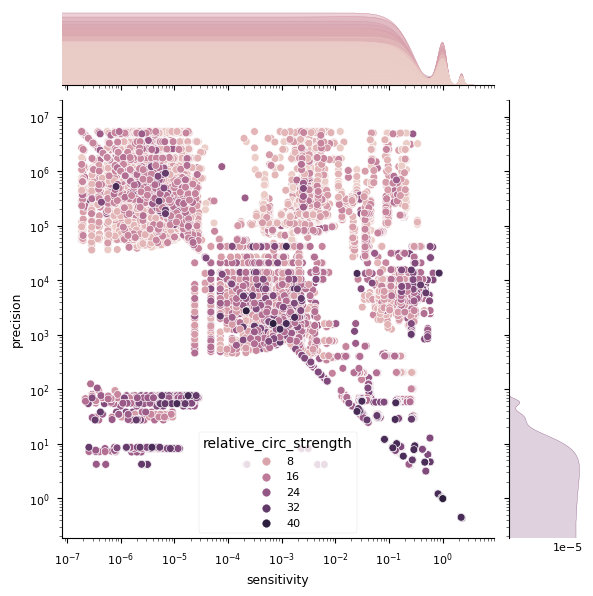

<Figure size 1000x500 with 0 Axes>

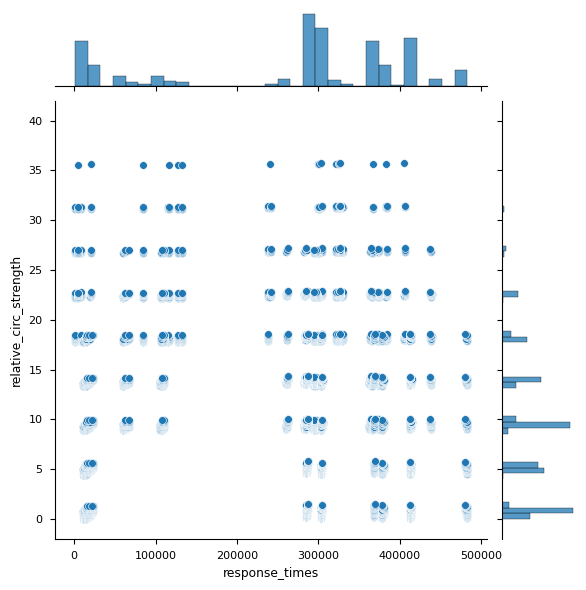

In [6]:
path_to_df = 'output/5_Keqs_exp/df.csv'
adf = pd.read_csv(path_to_df) 

plt.figure(figsize=(10,5))
# ax = plt.subplot(1,2,1)
sns.jointplot(adf, x='sensitivity', y='precision', hue='relative_circ_strength', alpha=1)
# sns.jointplot(adf[(adf['sensitivity'] > 0.01) & (adf['precision'] > 10000) & (adf['precision'] < 10**6) & (adf['species_type'] == 'unbound')], x='sensitivity', y='precision', hue='relative_circ_strength')
plt.xscale('log')
plt.yscale('log')

plt.figure(figsize=(10,5))
# ax = plt.subplot(1,2,2)
sns.jointplot(adf, x='response_times', y='relative_circ_strength')


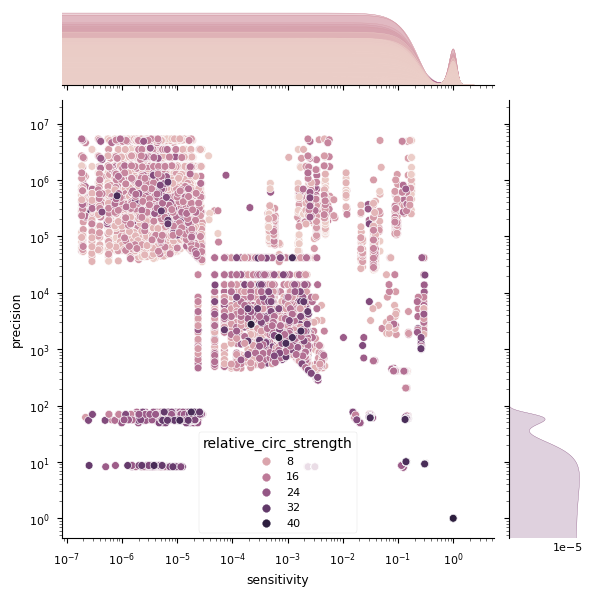

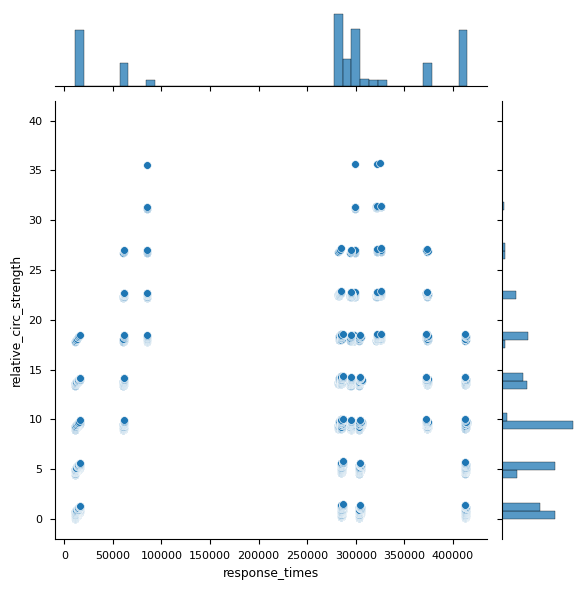

In [12]:
sns.jointplot(adf[(adf['species_type'] == 'unbound') & (adf['sample_name'] != 'RNA_0')],
                x='sensitivity', y='precision', hue='relative_circ_strength',
                alpha=1)
plt.xscale('log')
plt.yscale('log')

sns.jointplot(adf[(adf['species_type'] == 'unbound') & (adf['sample_name'] != 'RNA_0')], x='response_times', y='relative_circ_strength')


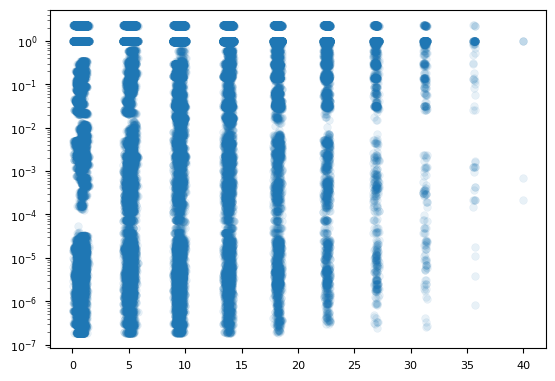

In [8]:
# adf[(adf['species_type'] == 'unbound') & (adf['species_name'] != model.species[input_species_idx].name)]
# plt.scatter(adf['relative_circ_strength'], adf['sensitivity'] / adf['precision'], alpha=0.1)
plt.scatter(adf['relative_circ_strength'], adf['sensitivity'] , alpha=0.1)
# plt.xscale('log')
plt.yscale('log')